In [1]:
import numpy as np
import pandas as pd
import os
import time
import random
import matplotlib.pyplot as plt 
import seaborn as sns

from glob import glob
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from skimage.feature import hog

import PIL
import cv2
import pickle

# Reading data

In [2]:
df = pd.read_csv("Training_data/data.csv")

In [3]:
df.head()

,Unnamed: 0,Img_path,Name,Name_box,Surname,Surname_box,Img_path_name,Img_path_surname
0,0,Training_data/signatures/img0.jpg,DZMITRY,"[[656, 185], [922, 181], [923, 221], [657, 225]]",LESZCZYŃSKI,"[[960, 180], [1379, 173], [1380, 213], [961, 2...",Training_data/names/img0.jpg,Training_data/surnames/img0.jpg
1,0,Training_data/signatures/img1.jpg,CYPRIAN,"[[582, 195], [970, 176], [973, 226], [584, 245]]",KUROWSKI,"[[1025, 173], [1470, 151], [1472, 201], [1028,...",Training_data/names/img1.jpg,Training_data/surnames/img1.jpg
2,0,Training_data/signatures/img2.jpg,MARZENNA,"[[427, 185], [934, 168], [937, 235], [429, 252]]",KĘDZIERSKA,"[[998, 166], [1632, 144], [1634, 210], [1001, ...",Training_data/names/img2.jpg,Training_data/surnames/img2.jpg
3,0,Training_data/signatures/img3.jpg,JOWITA,"[[581, 139], [896, 166], [892, 215], [577, 188]]",NOWAKOWSKA,"[[949, 170], [1473, 215], [1469, 265], [945, 2...",Training_data/names/img3.jpg,Training_data/surnames/img3.jpg
4,0,Training_data/signatures/img4.jpg,NIKODEM,"[[725, 217], [997, 183], [1002, 215], [729, 250]]",WALCZAK,"[[1036, 178], [1308, 144], [1312, 176], [1040,...",Training_data/names/img4.jpg,Training_data/surnames/img4.jpg


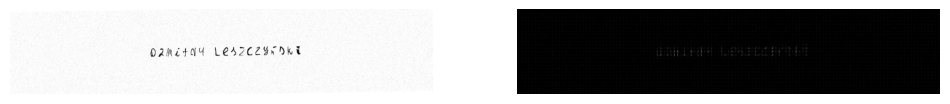

In [51]:
path1 = df["Img_path"].iloc[0]
example_image =  np.asarray(PIL.Image.open(path1))
hog_features,visualized = hog(example_image,orientations=9,pixels_per_cell=(16,16),
                              cells_per_block=(2,2),
                              visualize=True
                             )

fig = plt.figure(figsize=(12,6))
fig.add_subplot(1,2,1)
color = cv2.cvtColor(example_image,cv2.COLOR_GRAY2RGB)
plt.imshow(color,cmap="gray")
plt.axis("off")
fig.add_subplot(1,2,2)
plt.imshow(visualized,cmap="gray")
plt.axis("off")
plt.show()

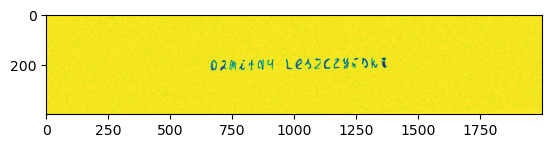

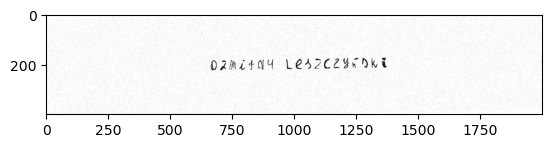

In [52]:
plt.imshow(example_image)
plt.show()
color = cv2.cvtColor(example_image,cv2.COLOR_GRAY2RGB)
plt.imshow(color)
plt.show()

# Visualizations

In [53]:
def box_read(box):
    temp = box.replace("]","").replace("[","").split(",")
    return [[int(temp[0]),int(temp[1])],[int(temp[2]),int(temp[3])],[int(temp[4]),int(temp[5])],[int(temp[6]),int(temp[7])]]

In [84]:
def draw_boxes(img, ractangle,color):
    if len(img.shape)==2:
        img = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)
    height = np.array(img).shape[0]
    img = cv2.rectangle(img,ractangle[0],ractangle[1],color = color,thickness=3)
    return img

In [85]:
box = [ df["Name_box"].iloc[0],df["Surname_box"].iloc[0]]
box[0] = box_read(box[0])
box[1] = box_read(box[1])

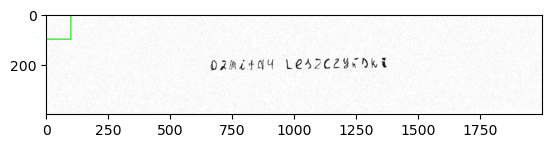

In [87]:
img = draw_boxes(example_image,[(0,0),(100,100)],(0,255,0))
plt.imshow(img)

In [88]:
def check_if_text(box,ractangle):
    for i in range(ractangle[0][0],ractangle[1][0]+1):
        for j in range(ractangle[0][1],ractangle[1][1]+1):
            result = cv2.pointPolygonTest(np.array(box[0]), (i,j), False)
            if result>=0:
                #print(i,j)
                return True
            result = cv2.pointPolygonTest(np.array(box[1]), (i,j), False)
            if result>=0:
                #print(i,j)
                return True
    return False
            

In [108]:
def draw_all_ractangles(box,img):
    ractangle_x_size = 50
    ractangle_y_size = 50
    shape = example_image.shape
    #shape =(40,40)
    for i in range(0,shape[1],ractangle_x_size):
        for j in range(0,shape[0],ractangle_y_size):
            ractangle = [[i,j],[i+ractangle_x_size,j+ractangle_y_size]]
            img = draw_boxes(img, ractangle,(255,0,0))
    for i in range(0,shape[1],ractangle_x_size):
        for j in range(0,shape[0],ractangle_y_size):
            ractangle = [[i,j],[i+ractangle_x_size,j+ractangle_y_size]]
            if(check_if_text(box,ractangle)):
                img = draw_boxes(img, ractangle,(0,255,0))
    plt.figure(figsize=(10, 8))
    plt.imshow(img)
    plt.show()

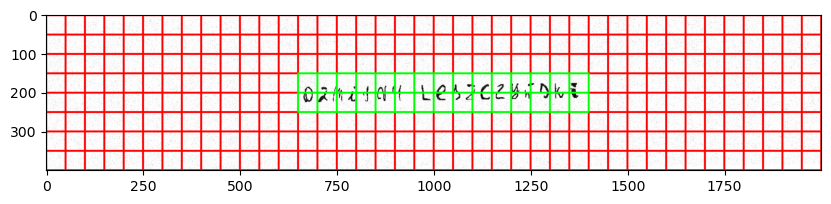

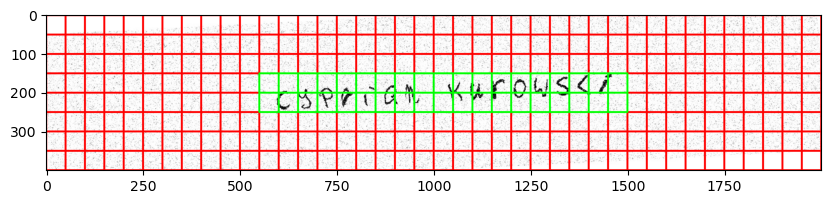

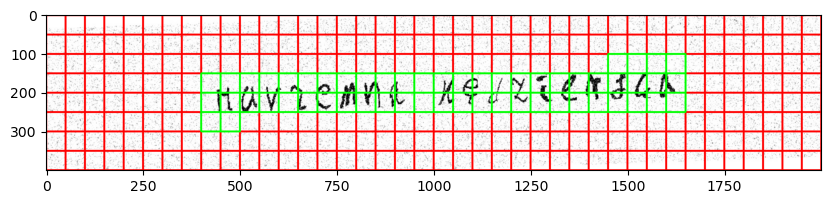

In [135]:
for i in range(3):
    path1 = df["Img_path"].iloc[i]
    img =  np.asarray(PIL.Image.open(path1))
    box = [ df["Name_box"].iloc[i],df["Surname_box"].iloc[i]]
    box[0] = box_read(box[0])
    box[1] = box_read(box[1])
    draw_all_ractangles(box,img)

# Creating data for training

In [131]:
X_train_true = []
X_train_false = []

In [132]:
for i in range(100):
    print(i)
    path1 = df["Img_path"].iloc[i]
    img =  np.asarray(PIL.Image.open(path1))
    box = [ df["Name_box"].iloc[i],df["Surname_box"].iloc[i]]
    box[0] = box_read(box[0])
    box[1] = box_read(box[1])
    ractangle_x_size = 50
    ractangle_y_size = 50
    shape = example_image.shape
    for i in range(0,shape[1],ractangle_x_size):
        for j in range(0,shape[0],ractangle_y_size):
            ractangle = [[i,j],[i+ractangle_x_size,j+ractangle_y_size]]
            if(check_if_text(box,ractangle)):
                X_train_true.append(img[ractangle[0][1]:ractangle[1][1],ractangle[0][0]:ractangle[1][0]])
            else:
                X_train_false.append(img[ractangle[0][1]:ractangle[1][1],ractangle[0][0]:ractangle[1][0]])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


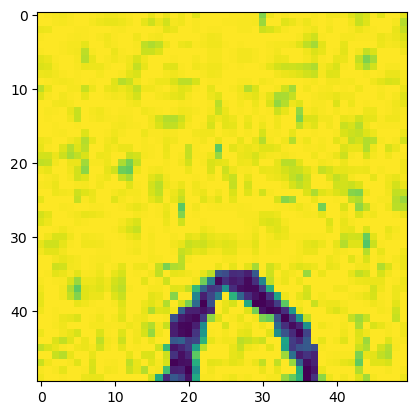

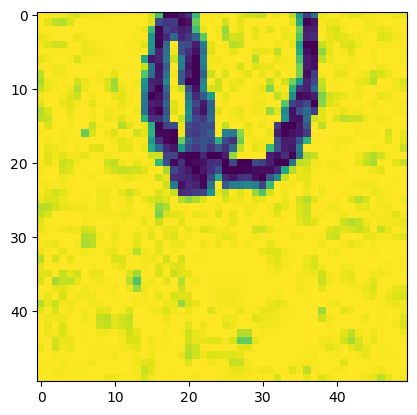

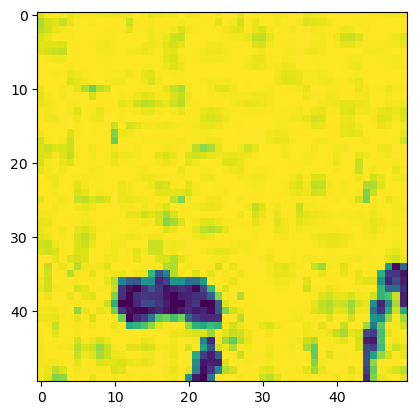

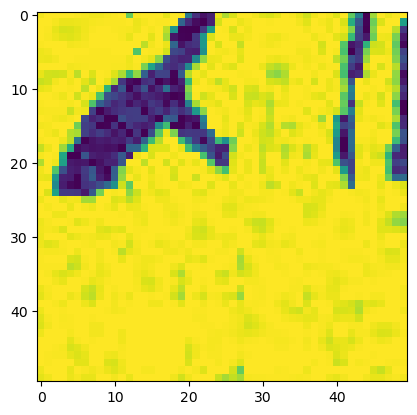

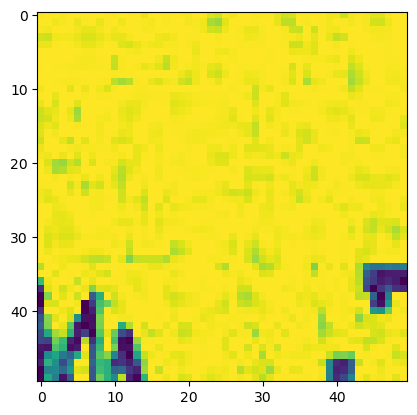

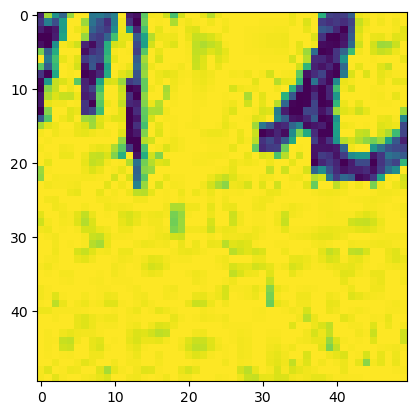

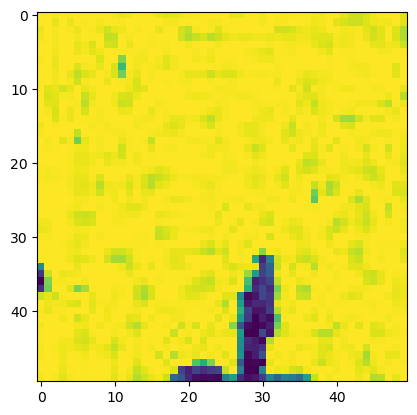

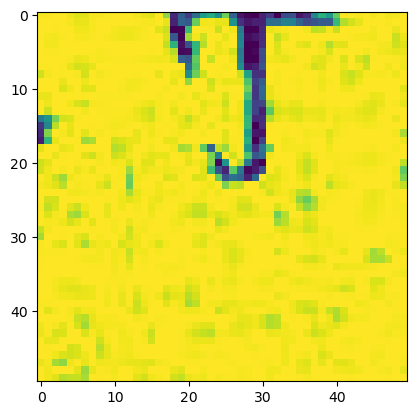

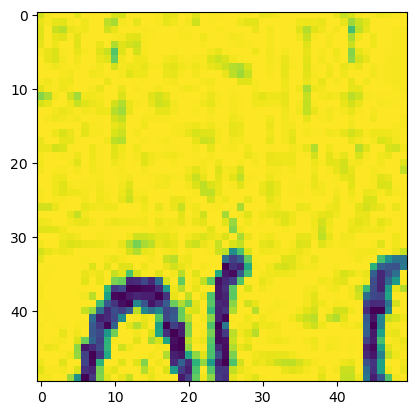

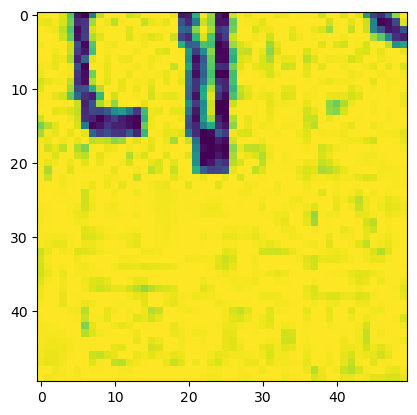

In [133]:
for i in range(10):
    plt.imshow(X_train_true[i])
    plt.show()

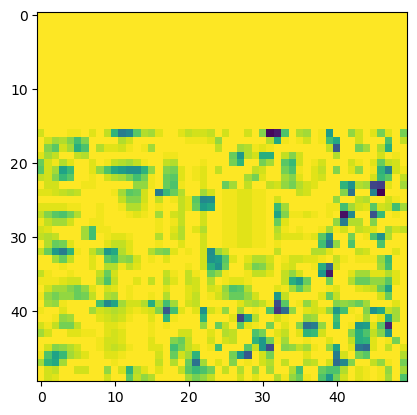

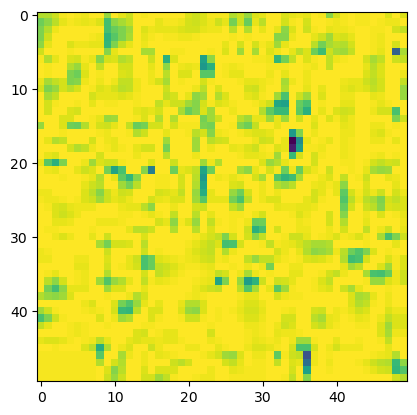

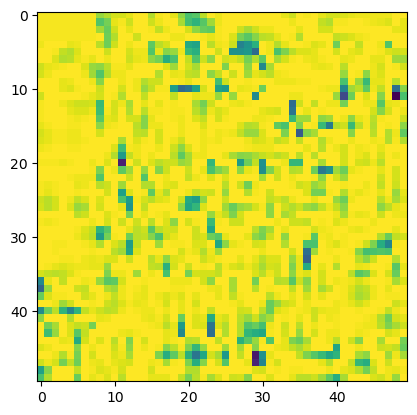

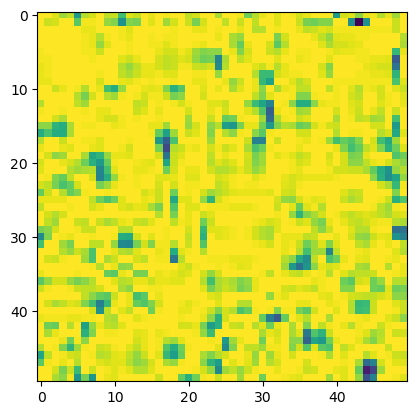

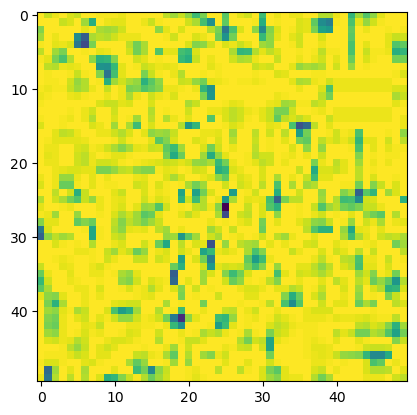

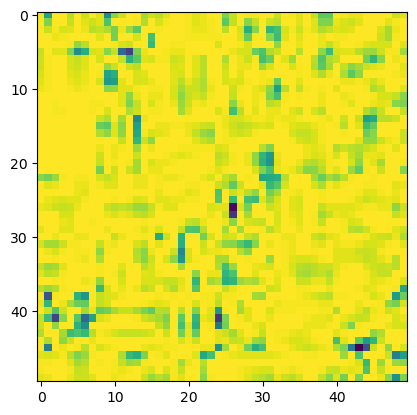

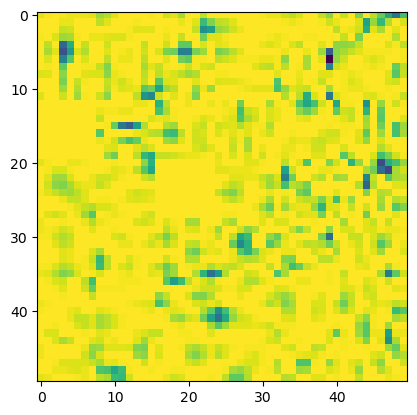

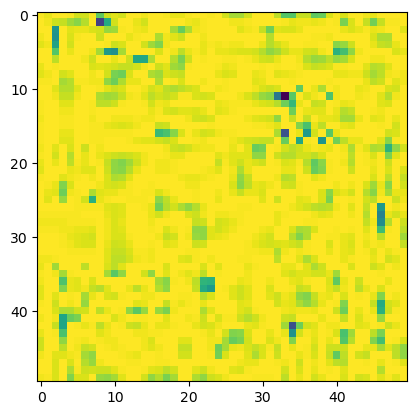

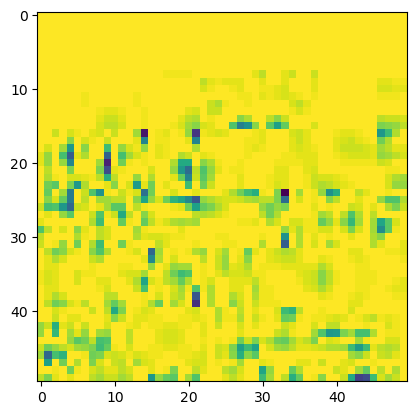

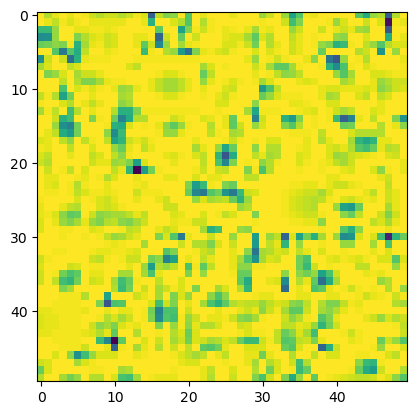

In [134]:
for i in range(10):
    plt.imshow(X_train_false[i])
    plt.show()

In [136]:
print(len(X_train_true))
print(len(X_train_false))

5423
26577


In [142]:
x = np.concatenate((np.array(X_train_true),np.array(X_train_false)),axis=0)
y = np.concatenate((np.ones(len(X_train_true)),np.zeros(len(X_train_false))),axis=0)

In [149]:
print(x.shape)
print(y.shape)

(32000, 50, 50)
(32000,)


In [152]:
shape = x.shape
x = x.reshape(shape[0],shape[1]*shape[2])
print(x.shape)

(32000, 2500)


# Training

In [153]:
svc = SVC()
svc.fit(x,y)

SVC()

# Testing

In [159]:
test = np.array(img[100:150,100:150])
shape = test.shape
test = test.reshape(shape[0]*shape[1])

In [162]:
svc.predict([test])

array([0.])

(400, 2000)


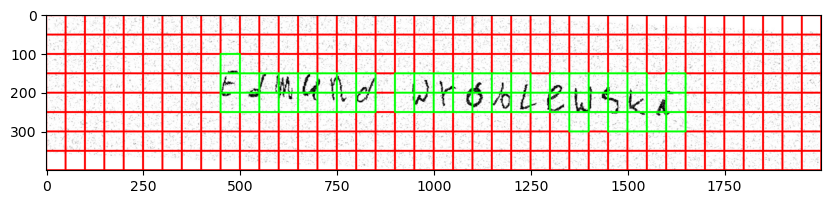

In [175]:
path1 = df["Img_path"].iloc[200]
img =  np.asarray(PIL.Image.open(path1))
canvas = img.copy()
ractangle_x_size = 50
ractangle_y_size = 50
shape = img.shape
print(shape)
#shape =(40,40)
for i in range(0,shape[1],ractangle_x_size):
    for j in range(0,shape[0],ractangle_y_size):
        ractangle = [[i,j],[i+ractangle_x_size,j+ractangle_y_size]]
        canvas = draw_boxes(canvas, ractangle,(255,0,0))
for i in range(0,shape[1],ractangle_x_size):
    for j in range(0,shape[0],ractangle_y_size):
        ractangle = [[i,j],[i+ractangle_x_size,j+ractangle_y_size]]
        cut_img = img[ractangle[0][1]:ractangle[1][1],ractangle[0][0]:ractangle[1][0]]
        cut_img = cut_img.reshape(cut_img.shape[0]*cut_img.shape[1])
        if(svc.predict([cut_img])[0]>0.5):  
            canvas = draw_boxes(canvas, ractangle,(0,255,0))
plt.figure(figsize=(10, 8))
plt.imshow(canvas)
plt.show()